# Modeling
To actually test the performance of these new datasets, we will try using them for machine learning! Here we will use a function I developed in another notebook to compare the features (the raw version with the highly correlated variables removed). We can run this kind of like an experiment, and the control will be the performance of just the application data in this function when submitted to the competition. I've already recorded that performance, so we can list out our control and our two test conditions:

For all datasets, use the model shown below (with the exact hyperparameters).

+ control: only the data in the **Crashes** files.
+ test one: the data in Crashes files with selective feature engineering of the data recorded from the **people and vehicle** files
+ test two: test one file with highly correlated variables removed.

In [6]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
# File system manangement
import os

plt.style.use('fivethirtyeight')

In [45]:
!pip install lightgbm
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt
from sklearn import preprocessing

In [106]:
def model(features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['RD_NO']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['RD_NO', 'TARGET'])

    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
#     test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 2002)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
#     test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 2002)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
#         test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
#     submission = pd.DataFrame({'RD_NO': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [73]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

## Control
The first step in any experiment is establishing a control. For this we will use the function defined above (that implements a Gradient Boosting Machine model) and the single main data source (crashes only).

In [47]:
print(os.listdir("../input"))

['Traffic_Crashes_-_Crashes.csv', 'Traffic_Crashes_-_People.csv', 'Traffic_Crashes_-_Vehicles.csv']


In [118]:
# this proces has to be done very beginning, but adding it now. 

categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK']
dtypes = dict.fromkeys(categoricals, 'category')

train_control = pd.read_csv('../input/Traffic_Crashes_-_Crashes.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

# imputed Data due to the memory lost less than 2017 data has lots of missing data anyway.
train_control['YEAR'] = pd.DatetimeIndex(train_control['CRASH_DATE']).year

mask = train_control['YEAR']>2017

train_control=train_control.loc[mask,:]

In [119]:
train_control.shape

(123297, 49)

In [120]:
# set the TARGET
train_control['TARGET'] = train_control['DAMAGE'].map(lambda x: 1 if x=='OVER $1,500' else 0)

#drop original feature DAMAGE
train_control = train_control.drop(columns='DAMAGE')

In [121]:
# drop some location columns and times to save memory 
drop_columns=['STREET_NO','LATITUDE','LONGITUDE','LOCATION','STREET_NAME','CRASH_DATE', 'DATE_POLICE_NOTIFIED']

#drop the features
train_control = train_control.drop(columns=drop_columns)

Since we have taken the time to write a function, using it is simple. The function above returns, 
+ a fi dataframe of feature importances
+ a metrics dataframe with train and validation performance.

In [122]:
train_control.shape

(123297, 42)

In [123]:
fi, metrics = model(train_control)

Training Data Shape:  (123297, 549)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.753719	train's binary_logloss: 0.58681	valid's auc: 0.727369	valid's binary_logloss: 0.598025
[400]	train's auc: 0.774879	train's binary_logloss: 0.572856	valid's auc: 0.727787	valid's binary_logloss: 0.597161
[600]	train's auc: 0.791015	train's binary_logloss: 0.561196	valid's auc: 0.727737	valid's binary_logloss: 0.596944
Early stopping, best iteration is:
[546]	train's auc: 0.787149	train's binary_logloss: 0.564084	valid's auc: 0.727957	valid's binary_logloss: 0.596889
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.753911	train's binary_logloss: 0.586191	valid's auc: 0.719867	valid's binary_logloss: 0.605259
[400]	train's auc: 0.775846	train's binary_logloss: 0.571898	valid's auc: 0.722556	valid's binary_logloss: 0.603193
[600]	train's auc: 0.791179	train's binary_logloss: 0.560719	valid's auc: 0.722256	valid's binary_logloss: 0.6

In [124]:
metrics

,fold,train,valid
0,0,0.787149,0.727957
1,1,0.785687,0.722823
2,2,0.805605,0.724049
3,3,0.791023,0.728523
4,4,0.775110,0.719393
5,overall,0.788915,0.724551


+ The control slightly overfits because the training score is higher than the validation score. 
>we already perform some regularization in this model by using reg_lambda and reg_alpha as well as early stopping but other regularization technique might be required.

+ We can visualize the feature importance with another function, plot_feature_importances. The feature importances may be useful when it's time for feature selection.

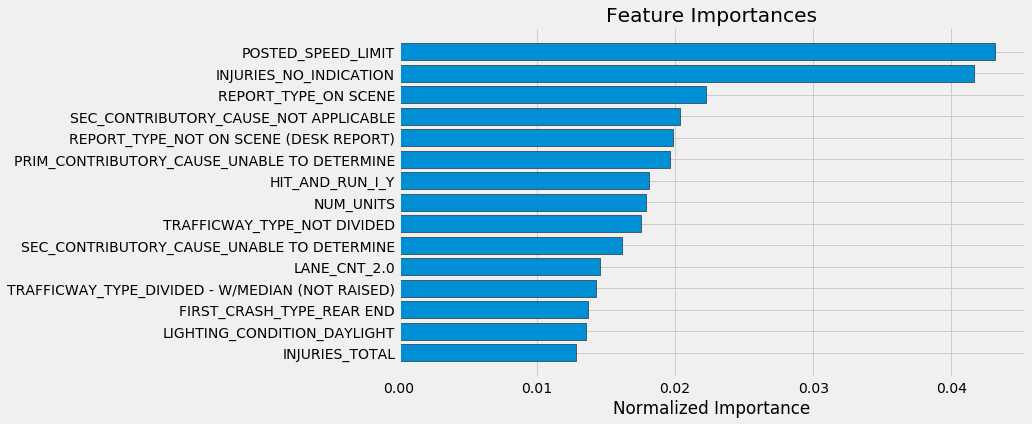

In [125]:
fi_sorted = plot_feature_importances(fi)

In [85]:
train_control.STREET_NO.nunique()

10127

## Test One
Let's conduct the first test. We will just need to pass in the data to the function, which does most of the work for us.

In [110]:
train = pd.read_csv('train_people_vehicle_corrs_removed.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

In [111]:
train['YEAR'] = pd.DatetimeIndex(train['CRASH_DATE']).year

mask = train['YEAR']>2017

train=train.loc[mask,:]

In [112]:
# drop some location columns and times to save memory 
drop_columns=['STREET_NO','LATITUDE','LONGITUDE','LOCATION','STREET_NAME','CRASH_DATE', 'DATE_POLICE_NOTIFIED']

#drop the features
train = train.drop(columns=drop_columns)

In [113]:
train.shape

(123297, 828)

In [126]:
train.INJURIES_NO_INDICATION

0         2.0
1         1.0
2         2.0
3         2.0
4         2.0
         ... 
123292    1.0
123293    2.0
123294    1.0
123295    1.0
123296    1.0
Name: INJURIES_NO_INDICATION, Length: 123297, dtype: object

In [114]:
fi_raw, metrics_raw = model(train)

Training Data Shape:  (123297, 3881)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.769244	train's binary_logloss: 0.574559	valid's auc: 0.735107	valid's binary_logloss: 0.590767
[400]	train's auc: 0.794872	train's binary_logloss: 0.556697	valid's auc: 0.736613	valid's binary_logloss: 0.58935
[600]	train's auc: 0.813655	train's binary_logloss: 0.542292	valid's auc: 0.737154	valid's binary_logloss: 0.588735
Early stopping, best iteration is:
[529]	train's auc: 0.807542	train's binary_logloss: 0.547112	valid's auc: 0.737385	valid's binary_logloss: 0.588786
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.767638	train's binary_logloss: 0.575404	valid's auc: 0.737794	valid's binary_logloss: 0.595079
[400]	train's auc: 0.793442	train's binary_logloss: 0.557733	valid's auc: 0.739981	valid's binary_logloss: 0.592944
[600]	train's auc: 0.812956	train's binary_logloss: 0.542867	valid's auc: 0.740748	valid's binary_logloss: 0.

In [115]:
metrics_raw

,fold,train,valid
0,0,0.807542,0.737385
1,1,0.807994,0.741002
2,2,0.829412,0.737910
3,3,0.808545,0.741959
4,4,0.792659,0.735374
5,overall,0.809231,0.738617


Based on these numbers, the engineered features perform better than the control case.

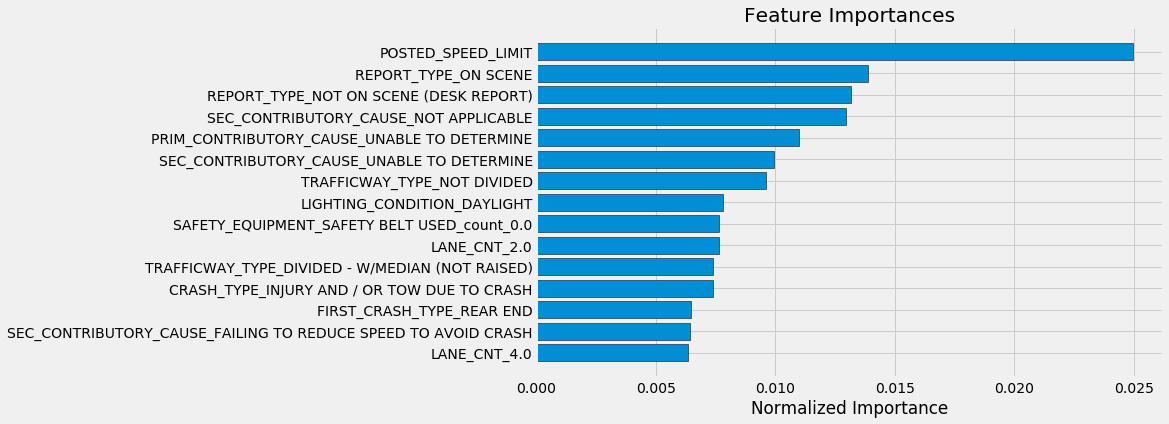

In [116]:
fi_raw_sorted = plot_feature_importances(fi_raw)

Examining the feature improtances, Let's find the percentage of the top 100 most important features that we made. However, rather than just compare to the original features, we need to compare to the one-hot encoded original features. These are already recorded for us in fi (from the original data).

In [127]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the people and vehicle data = %d.00' % len(new_features))

% of Top 100 Features created from the people and vehicle data = 49.00


# Results
After all that work, we can say that including the extra information did improve performance! The model is definitely not optimized to our data, but we still had a noticeable improvement over the original dataset when using the calculated features. Let's officially summarize the performances:

| Experiment | Train AUC | Validation AUC |
|------------|-----------|----------------|
|  Control   |  0.788915 |    0.724551    |
|  Test one  |  0.809231 |    0.738617    |

